## Imports

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import entropy, anderson

## Loading in Datasets

In [26]:
loaded_data = pd.read_csv('datasets/predictions_actual.csv')
preds = loaded_data['Predictions']
actual = loaded_data['Actual']

## Defining a Loss Function

The loss function used here is the **Mean Squared Error (MSE)**, calculated as:

$$\text{Loss} = \frac{1}{2}(\hat{y} - y)^2\\$$

Where:
$\\    \hat{y} \text{ is the predicted value (forecasted value).}\\$
$y     \text{ is the actual observed value.}$

In [27]:
def loss_function(yhat, y):
    return 0.5 * (yhat - y) ** 2

In [28]:
print(f'The average loss is: {np.mean(loss_function(preds, actual)):.3f}')
print(f'The total loss is:   {np.sum(loss_function(preds, actual)):.3f}')

The average loss is: 0.148
The total loss is:   38.840


In [29]:
def percentage_loss(yhat, y):
    return np.abs(yhat - y) / y * 100

In [30]:
print(f'Average loss of: {np.mean(percentage_loss(preds, actual)):.2f}%')

Average loss of: 3.82%


In [31]:
def log_likelihood(yhat, y):
    residuals = y - yhat
    sigma_squared = np.var(residuals)
    n = len(actual)
    log_likelihood_value = (-n / 2) * np.log(2 * np.pi * sigma_squared) - (1 / (2 * sigma_squared)) * np.sum(residuals ** 2)

    return log_likelihood_value

## Goodness of Fit

In [32]:
def r_score(yhat, y):
    return r2_score(yhat, y)

print(f'The goodness of fit with an R^2 score of: {r_score(preds, actual):.3f}.\nThis indicates an accuracy of: {r_score(preds, actual) * 100:.2f}%')

The goodness of fit with an R^2 score of: 0.905.
This indicates an accuracy of: 90.45%


## Plotting

In [33]:
def plot_actual_prediction_residuals(actual, preds):
    residuals = actual - preds

    plt.figure(figsize=(15, 8))  # Create the first figure
    plt.plot(actual.index, actual, color='b', label='Actual Data', marker='o')
    plt.plot(preds.index, preds, color='r', label='Predicted Data', linestyle='dashed', marker='x')
    plt.title('Actual vs Predicted')
    plt.xlabel('index')  # how to convert to year?
    plt.ylabel('CDS Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, residuals, color='g', label='Residuals', marker='x')
    plt.axhline(0, color='black', linestyle='dashed')
    plt.title('Residuals')
    plt.xlabel('index')  # how to convert to year?
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

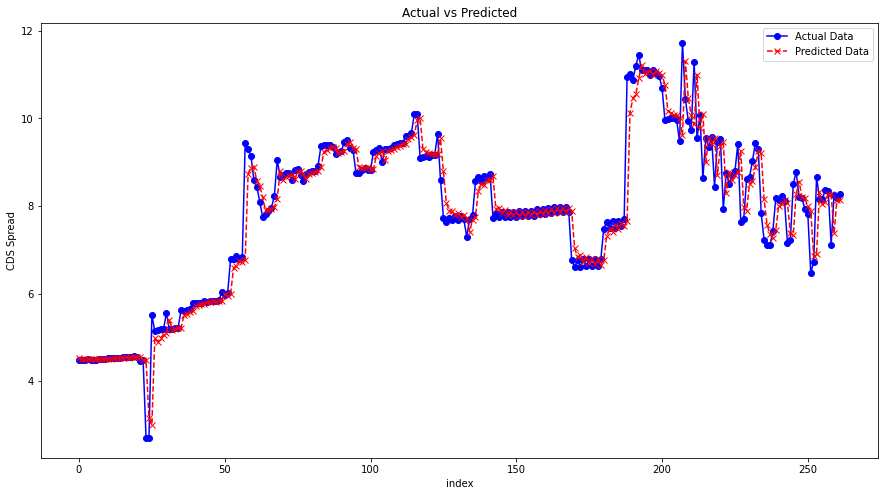

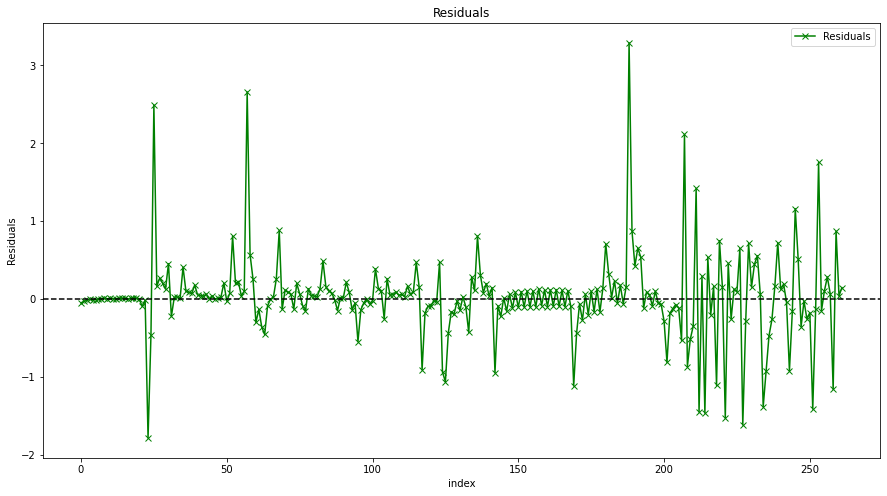

In [34]:
plot_actual_prediction_residuals(actual, preds)

## Kolmogorov-Smirnov Test

In [35]:
def perform_ks_test_actual_vs_preds(actual, preds):
    ks_stat, p_value = stats.ks_2samp(actual, preds)

    print(f"KS Statistic: {ks_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

    if p_value > 0.05:
        print("The actual and predicted data likely come from the same distribution (fail to reject H0).")
    else:
        print("The actual and predicted data do not come from the same distribution (reject H0).")

perform_ks_test_actual_vs_preds(actual, preds)

KS Statistic: 0.057
P-value: 0.785
The actual and predicted data likely come from the same distribution (fail to reject H0).


## Anderson-Darling Test

In [36]:
print(anderson(actual-preds))

AndersonResult(statistic=18.95256198711263, critical_values=array([0.568, 0.646, 0.775, 0.905, 1.076]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.024720429621519567, scale=0.5449882316803782)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


## Kullback–Leibler (KL) divergence

In [37]:
kl_divergence = entropy(actual, preds)
print(kl_divergence)

0.002551275542288419


## Coverage Probability

In [38]:
def calculate_picp(actual, lower_bounds, upper_bounds):
    within_bounds = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    picp = np.mean(within_bounds)

    return picp

In [39]:
def generate_prediction_intervals(actual, preds):
    margin = np.std(actual - preds) * 1.96  # for 95% CI

    lower_bounds = preds - margin
    upper_bounds = preds + margin

    return lower_bounds, upper_bounds

In [40]:
lower_bounds, upper_bounds = generate_prediction_intervals(actual, preds)
picp_value = calculate_picp(actual, lower_bounds, upper_bounds)

print(f"Prediction Interval Coverage Probability (PICP) for 95% CI: {picp_value:.4f}.\nThis means {picp_value*100:.2f}% of the data falls within the 95% CI.")

Prediction Interval Coverage Probability (PICP) for 95% CI: 0.9351.
This means 93.51% of the data falls within the 95% CI.


In [41]:
def plot_actual_prediction_ci(actual, lower_bounds, upper_bounds):
    inside_ci = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    plt.figure(figsize=(15, 8))

    plt.scatter(actual.index[~inside_ci], actual[~inside_ci], color='r', label='Actual outside CI')
    plt.fill_between(actual.index, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.xlabel('index')  # year?
    plt.ylabel('CDS Spread')
    plt.title('Actual vs Predicted with 95% Confidence Interval')
    plt.legend()
    plt.show()

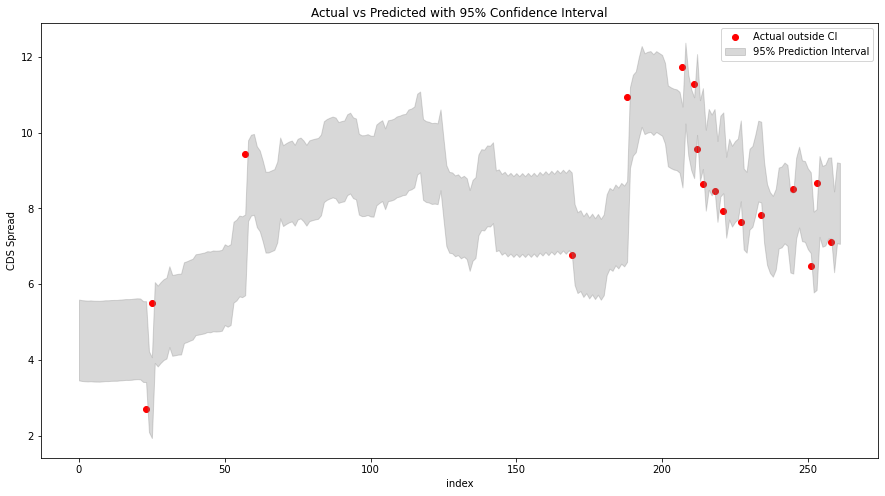

In [42]:
plot_actual_prediction_ci(actual, lower_bounds, upper_bounds)

## Mean Interval Score

In [43]:
def calculate_mean_interval_score(actual, lower_bounds, upper_bounds, alpha=0.05):
    interval_width = upper_bounds - lower_bounds
    penalty_lower = np.maximum(0, lower_bounds - actual)
    penalty_upper = np.maximum(0, actual - upper_bounds)
    mis_values = interval_width + (2 / alpha) * (penalty_lower + penalty_upper)
    mis = np.mean(mis_values)

    return mis

In [44]:
mis_value = calculate_mean_interval_score(actual, lower_bounds, upper_bounds)
print(f"Mean Interval Score (MIS): {mis_value:.4f}")

Mean Interval Score (MIS): 3.7801
